# MA934 - class 4

## Deadline: 12:00 noon on Thursday 3 November 

You should make at least one commit to your repository per computational task below - usually more.

For this assignment, you must create a new Jupyter notebook called MA934_Class4_UniID.ipynb to contain the implementations that you write. You can separate out individual tasks if you prefer, but the full submission should be made as a single .zip via [our website](https://warwick.ac.uk/fac/sci/mathsys/courses/msc/ma934/resources/assessedwork/ma934declaration). The platform will not allow you to upload more than one file.

A few tips:
- please make sure to debug intermediate outputs as you code along. You are welcome to design smaller test cases and toy problems to verify your work (even if they are not part of the final submission).
- consider possible forms of input or arguments and make sure your solution can cope with *interesting* cases.
- do not forget to comment your code and use Markdown cells to explain what you are doing. A perfectly functional solution with no information about the thought process will not receive more than a subset of the points (~$70\%$ depending on the difficulty of the problem and how transparent the algorithm flow is). 
- generally getting used to writing tidy solution is good practice. Feel free to use [online resources](https://www.ibm.com/docs/en/watson-studio-local/1.2.3?topic=notebooks-markdown-jupyter-cheatsheet) for editing guidance.

## Task 1 - Solving a simple linear programme

In [1]:
# Import libraries
import time
import numpy as np
from numpy import linalg as la
import random
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

Vertices $(x_1, x_2)$ are found by finding the points of intersections between those lines which intersect, namely

$$1: \; 2\, x_1 + x_2 = 70 $$
$$2: \; x_1 + 3\, x_2 = 90 $$
$$3:  \; 3\, x_1 + x_2 = 46 $$
$$4:  \; x_1 + 4\, x_2 = 52 $$

This is done by solving four systems each of two linear equations

In [4]:
vertices = np.zeros((4,2))

# system of equations 2 and 3
A = np.array([[1,3],[3,1]])
b = np.array([90,46])
vertices[0,:] = la.solve(A,b)

# system of equations 1 and 2
A = np.array([[2,1],[1,3]])
b = np.array([70,90])
vertices[1,:] = la.solve(A,b)

# system of equations 1 and 4
A = np.array([[2,1],[1,4]])
b = np.array([70,52])
vertices[2,:] = la.solve(A,b)

# system of equations 3 and 4
A = np.array([[3,1],[1,4]])
b = np.array([46,52])
vertices[3,:] = la.solve(A,b)

vertices

array([[ 6.        , 28.        ],
       [24.        , 22.        ],
       [32.57142857,  4.85714286],
       [12.        , 10.        ]])

Plotting the search space. The feasible set is defined as the paralellogram whose vertices are black dots 

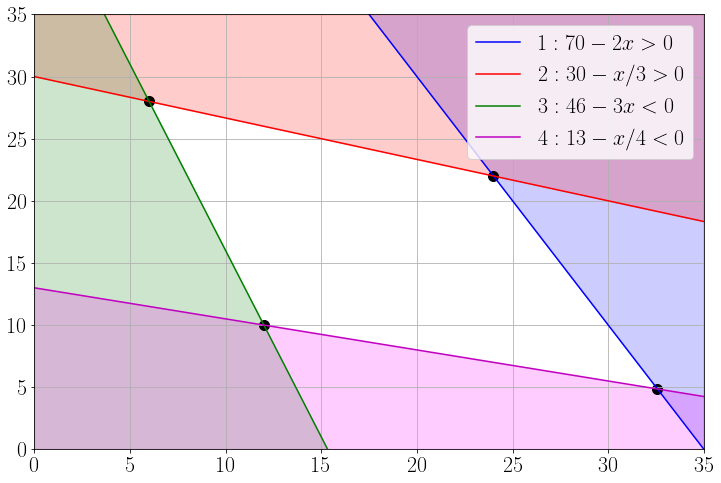

In [5]:
# reasonable search space for x1 is (0,35) from constraint 1
x = np.arange(0.0, 35.01, 0.1)

# defining functions returning the four constraints in terms of x2
def f1(inputlist):
    return [70.0 - 2.0*i for i in inputlist]

def f2(inputlist):
    return [30.0 - i/3.0 for i in inputlist]

def f3(inputlist):
    return [46.0 - 3.0*i for i in inputlist]

def f4(inputlist):
    return [13.0 - i/4.0 for i in inputlist]


# Plot inequalities
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12, 8))

plt.plot(x, f1(x), "b-", label = "$1: 70-2x>0$")
plt.fill_between(x, f1(x), 35.0, color='blue', alpha=.2)

plt.plot(x, f2(x), "r-", label = "$2: 30-x/3>0$")
plt.fill_between(x, f2(x), 35.0, color='red', alpha=.2)

plt.plot(x, f3(x), "g-", label = "$3: 46-3x<0$")
plt.fill_between(x, 0.0, f3(x), color='green', alpha=.2)

plt.plot(x, f4(x), "m-", label = "$4: 13-x/4<0$")
plt.fill_between(x, 0.0, f4(x), color='magenta', alpha=.2)

# points of intersection encompassing paralellogram
plt.scatter(vertices[:,0], vertices[:,1], color='k', s=100)

plt.legend(loc="upper right")

plt.xlim([0.0, 35.0])
plt.ylim([0.0, 35.0])

plt.grid()
plt.show()

Checking the cost function evaluated at the vertices

In [6]:
# cost function we aim to minimize
def cost(x1,x2):
    return -40*x1 - 60*x2

In [7]:
for k in range(4):
    print('x1 = %.1f' % vertices[k,0])
    print('x2 = %.1f' % vertices[k,1])
    print('Cost: %.1f' % cost(vertices[k,0],vertices[k,1]))
    print('\n')

x1 = 6.0
x2 = 28.0
Cost: -1920.0


x1 = 24.0
x2 = 22.0
Cost: -2280.0


x1 = 32.6
x2 = 4.9
Cost: -1594.3


x1 = 12.0
x2 = 10.0
Cost: -1080.0




Our solution is therefore $(x_1, x_2) = (24,22)$

## Task 2 - Dantzig simplex algorithm

Introducing slack variables $\{s_1, s_2, s_3, s_4\}$, we write the problem as follows:

$$\min_{\substack{(x_1, x_2) \in \mathbb{R}^2} } -40\, x_1 - 60\, x_2$$

subject to the constraints

$$\begin{align*}
2 x_1 + x_2 + s_1 &= 70 \\
x_1 + 3 x_2 + s_2 &= 90 \\
-3 x_1 - x_2 + s_3 &= -46 \\
-x_1 - 4 x_2 + s_4 &= -52
\end{align*}$$

In standard form we are solving:

$$\min_{\substack{\mathbf{x} \in \mathbb{R}^6} } f(\mathbf{x}) = \mathbf{c}\cdot\,\mathbf{x}$$

where

$$\mathbf{c} = 
\begin{pmatrix}
-40 & -60 & 0 & 0 & 0 & 0
\end{pmatrix}$$

subject to four equality constraints, represented in matrix form

$$A \mathbf{x} = \mathbf{b}$$

with

$$A = 
\begin{pmatrix}
2 & 1 & 1 & 0 & 0 & 0 \\
1 & 3 & 0 & 1 & 0 & 0 \\
-3 & -1 & 0 & 0 & 1 & 0 \\
-1 & -4 & 0 & 0 & 0 & 1 
\end{pmatrix}$$

$$\mathbf{x} = \begin{pmatrix}
x_1 \\
x_2 \\
s_1 \\
s_2 \\
s_3 \\
s_4
\end{pmatrix}$$

and

$$\mathbf{b} = \begin{pmatrix}
70 \\
90 \\
-46 \\
-52
\end{pmatrix}$$

and six non-negativity conditions
$$
x_1,x_2,s_1,s_2,s_3,s_4 \geq 0 .
$$

Finding a basic feasible vector in $\mathbb{R}^6$ for the vertex $(x_1,x_2) = (12,10)$

In [8]:
x1 = 12
x2 = 10

#Solving backwards for s_i's
s1 = 70 - 2*x1 - x2
s2 = 90 - x1 - 3*x2
s3 = 3*x1 + x2 - 46
s4 = x1 + 4*x2 - 52

x_bfv = np.array([x1,x2,s1,s2,s3,s4])
print(x_bfv)

[12 10 36 48  0  0]


Dantzig revised simplex algorithm

In [18]:
def Dantzig(x_bfv, A, c, track_guesses=False):
    # function which employs the Dantzig revised simplex algorithm for our
    # given linear programme, with the following inputs:
    # x_bfv: initial basic feasible vector (assuming it exists)
    # A: matrix giving equality constraints when problem is written in standard form
    # c: cost vector
    # track_guesses: allows us to see searches before we arrived at our optimal
    
    # get indices of the basic and non-basic variables and splitting A,c and basic
    # feasible vector into its basic and non-basic components accordingly
    idx_nonbasic = np.where(x_bfv == 0)[0]
    idx_basic = np.nonzero(x_bfv)[0]
    
    x_nonbasic = x_bfv[idx_nonbasic]
    x_basic = x_bfv[idx_basic]            # x basic
    
    A_basic = A[:,:idx_nonbasic[0]]       # B
    A_nonbasic = A[:,idx_nonbasic[0]:]    # N
    Ainv_basic = la.inv(A_basic)          # B^-1
    
    c_basic = c[:idx_nonbasic[0]]
    c_nonbasic = c[idx_nonbasic[0]:]
    
    # objective function f(x) = c x
    obj_cost = c_basic@x_basic
    
    # number of basic and non-basic variables
    N_b = len(x_basic)
    N_nb = len(x_nonbasic)

    # gradient of objective function
    gradf_nb = np.zeros(N_nb)
    
    # stores vertices searched by Dantzig and corresponding objective function value
    searched_vertices = np.array([x_basic[0],x_basic[1],obj_cost])
    
    # if our gradient is always decreasing in the algorithm we will check
    # remaining n-1 vertices
    l = 0
    while l < N_b-1:
        
        # get index to non-basic variable to make basic
        for i in range(N_nb):
            gradf_nb[i] = c[idx_nonbasic[i]] - c_basic@Ainv_basic@A[:,idx_nonbasic[i]]
        
        # terminate search if we arrive at point where we cannot decrease any
        # further
        if gradf_nb.min() >= 0:
            break
        
        # non_basic index
        q = idx_nonbasic[np.argmin(gradf_nb)]

        # get index to basic variable to make non-basic
        # w == column generation (a^hat pq)
        w = Ainv_basic@A[:,q]

        # sanity check to make sure problem is not unbounded
        if w.max() < 0:
            raise Exception('Error: Problem is unbounded')
        
        # xk stores xj/wj computations of which we require a non-negative
        # minimum as we seek to find basic variable xi which hits zero
        # first as non-basic variable x[q] increases
        xk = np.ones(N_b)*1e4
        
        for j in range(N_b):
            if w[j] >= 0:
                xk[j] = x_basic[j]/w[j]

        # basic index
        p = idx_basic[np.argmin(xk)]
        alpha = xk[p]

        # row reductions
        Ep = np.identity(N_b)
        Ep[:,p] = -w/w[p]
        Ep[p,p] = 1/w[p]

        Ainv_basic = Ep@Ainv_basic

        # swapping columns of A and c
        A[:,[q, p]] = A[:,[p, q]]
        c[[q, p]] = c[[p, q]]

        # updating x basic and objective cost
        x_basic = x_basic - alpha*w
        x_basic[p] = alpha
        obj_cost = c_basic@x_basic
        
        # update searched vertices
        new_eval = np.array([x_basic[0], x_basic[1], obj_cost])
        searched_vertices = np.vstack(( searched_vertices, new_eval ))
        
        l += 1
    
    # returns an array of three entries, with (list[0], list[1]) being the
    # solution to our LP, followed by the objective function evaluated at
    # the solution
    if track_guesses == True:
        return searched_vertices
    
    else:
        return searched_vertices[-1,:]

In [23]:
# inputs
x_bfv = np.array([x1,x2,s1,s2,s3,s4])
A = np.array([[2,1,1,0,0,0],[1,3,0,1,0,0],[-3,-1,0,0,1,0],[-1,-4,0,0,0,1]])
c = np.array([-40,-60,0,0,0,0])

# solution
LPsol = Dantzig(x_bfv, A, c, True)
print(LPsol)
print('\n')
print('Optimal solution found at vertex', LPsol[-1,:2], 'with objective cost', LPsol[-1,-1])

[[   12.    10. -1080.]
 [    6.    28. -1920.]
 [   24.    22. -2280.]]


Optimal solution found at vertex [24. 22.] with objective cost -2280.0


## Task 3 - Gradient descent

Consider the following optimisation problem in $\mathbb{R}^n$

$$\min_{\substack{\mathbf{x} \in \mathbb{R}^n} } f(\mathbf{x})$$

where $f(\mathbf{x})$ is the quartic function defined as

$$ f(\mathbf{x}) = \frac{1}{4} \left( (\mathbf{x} - \mathbf{x}_*)^T A\cdot (\mathbf{x} - \mathbf{x}_*)\right)^2 $$

with 

$$ A = \left( 
\begin{array}{ccccc} 
\frac{\lambda+1}{2} & \frac{\lambda - 1}{2} & 0 &\ldots & 0\\ 
\frac{\lambda-1}{2} & \frac{\lambda + 1}{2} & 0 &\ldots & 0\\
0 & 0 & 1 &\ldots & 0\\ 
\vdots & \vdots & \vdots &\ddots & \vdots\\ 
0 & 0 & 0 &\ldots & 1
\end{array}
\right),
$$
$$
\mathbf{x}_* = \left( \begin{array}{c}
\sqrt{2}\\
\sqrt{3}\\
1\\
\vdots\\
1
\end{array}
\right)
$$
and $\lambda > 0$ is a parameter that controls the shape of the objective function. A reasonable range of values for $\lambda$ is $\frac{1}{10} \leq \lambda \leq 10$.

* Write down the solution of this problem.
* Write down the eigenvalues of the matrix $A$.
* Derive a formula for the gradient, $\nabla f(\mathbf{x})$, at any point in $\mathbb{R}^n$.
* Use your results to implement the gradient descent algorithm in Python. Use your algorithm to numerically solve the above problem with $n=2$ and $\lambda=2$. A good initial point is $\mathbf{x}_0 = 5\,\mathbf{x}_*$.  A good tolerance is $\varepsilon = 10\, \epsilon_m$. **Note:** You will need to write your own *Golden Section Search* code as part of this task, which is a small subproblem in itself. Make sure you verify your implementation with smaller datasets before deploying it within the context of the larger problem.
* Plot how the distance from the minimum decreases as s function of the number of iterations and empirically determine the convergence rate of the algorithm.
* Determine empirically how the number of steps required to solve the problem varies with $\lambda$ when $n=3$.

*Write down the solution of this problem*

$$\mathbf{x} = \mathbf{x}_\star$$

*Write down the eigenvalues of the matrix $A$*

$$|A - \kappa I_n| = \big{(}\frac{\lambda+1}{2} - \kappa\big{)}\big{(}\frac{\lambda+1}{2} - \kappa\big{)}(1-\kappa)...(1-\kappa) - \big{(}\frac{\lambda+1}{2}\big{)}^2(1-\kappa)...(1-\kappa) = 0$$

$$\implies (1-\kappa)...(1-\kappa)(\lambda - (\lambda+1)\kappa + \kappa^2) = 0$$

$$\implies \kappa = 1, \; \frac{\lambda+1\pm\sqrt{(\lambda-1)^2}}{2}$$

$$\implies \kappa = 1, \; \lambda$$

*Derive a formula for the gradient, $\nabla f(\mathbf{x})$, at any point in $\mathbb{R}^n$.*

Letting

$$\mathbf{r = x - x_\star}$$

We compute the matrix derivative using the Chain Rule

*Use your results to implement the gradient descent algorithm in Python. Use your algorithm to numerically solve the above problem with $n=2$ and $\lambda=2$. A good initial point is $\mathbf{x}_0 = 5\,\mathbf{x}_\star$.  A good tolerance is $\varepsilon = 10\, \epsilon_m$. **Note:** You will need to write your own Golden Section Search code as part of this task, which is a small subproblem in itself. Make sure you verify your implementation with smaller datasets before deploying it within the context of the larger problem*

In [ ]:
# inputs
n = 2
lamb = 2
eps = 1e-15

# fixed point
xstar = np.ones(n)
xstar[0] = np.sqrt(2.0)
xstar[1] = np.sqrt(3.0)

# matrix
A = np.zeros((n,n))
A[0,0] = (lamb+1)/2
A[1,1] = (lamb+1)/2
A[0,1] = (lamb-1)/2
A[1,0] = (lamb-1)/2

# quartic function to be minimised and its corresponding gradient
def f(x):
    global A, xstar
    r = x-xstar
    return 0.25*(np.transpose(r)@A@r)**2

def df(x):
    global A, xstar
    r = x-xstar
    return (np.transpose(r)@A@r)*(A@r)

Custom Golden Search algorithm which will be needed to perform line minimisation

In [ ]:
def GoldenSearch(f, interval, tol):
    # function which searches for minimum of f(x) via a bracketing-and-bisection method
    # triple = (a c b) must bracket the minimum such that f(c) < f(a) and f(c) < f(b)
    # if maximum required enter -f as function
    
    [a, b] = interval
    w = (np.sqrt(5)-1)/2
    # choosing c (makes (c, b) the larger interval)
    c = (b + w*a)/(1 + w)
    
    # perform search until interval length falls below specified tolerance
    while b - a > tol:
        
        # case (c, b) is the larger interval
        if np.abs(b - c) > np.abs(c - a):
            x = c + (1 - w)*(b - c)
            if f(c) < f(x):
                [a, c, b] = [a, c, x] # case 1A: c bracketed by (a, x)
            else:
                [a, c, b] = [c, x, b] # case 1B: x bracketed by (c, b)
                
        # case (a, c) is the larger interval        
        else:
            x = c - (1 - w)*(c - a)
            if f(c) < f(x):
                [a, c, b] = [x, c, b] # case 2A: c bracketed by (x, b)
            else:
                [a, c, b] = [a, x, c] # case 2B: x bracketed by (a, c)
  
    
    return c

We now perform the gradient descent

In [ ]:
def gradient_descent(f, df, x0, tol, track_convergence=False):
    # function designed to find the __minimum__ of f(x) taking x in R^n using method of steepest descent
    # f: function to be minimised
    # df: gradient of f
    # x0: initial starting point
    # tol: tolerance required for convergence
    # track_convergence: if true we will keep track of the norm of df at each iteration
    
    xn = x0 # initial guess
    vn = -df(xn)/la.norm(df(xn)) # position vector
    guesses = xn # matrix which will store xn at each iteration
    
    # function which allows to find the line minimisation of f when implemented into Golden Search
    def line_minimiser(lamb):
        return f(xn + lamb*vn)
    
    while la.norm(df(xn)) > tol:
        #perform line minimisation using Golden Search
        lamb_min = GoldenSearch(line_minimiser, [0,10], 1e-10)
        
        #updating xn in direction of steepest descent
        xn = xn + lamb_min*vn
        
        #updating vn
        vn = -df(xn)/la.norm(df(xn))
        
        # stacking guesses vertically with our current estimation for xn
        if track_convergence == True:
            guesses = np.vstack((guesses,xn))

    
    if track_convergence == True:
        return guesses
    
    else:
        return xn

In [ ]:
gradient_descent(f, df, 5*xstar, eps, False)

Plot how the distance from the minimum decreases as a function of the number of iterations and empirically determine the convergence rate of the algorithm.

In [ ]:
x_guesses = gradient_descent(f, df, 5*xstar, eps, True)
N_iter = np.shape(x_guesses)[0]
rs = x_guesses - xstar*np.ones(np.shape(x_guesses))
                               
distances = np.zeros(N_iter)
for i in range(N_iter):
    distances[i] = la.norm(rs[i,0])
print(distances)

In [ ]:
#plotting
plt.rcParams.update({'font.size': 22})

plt.figure(figsize=(12, 8))
c = 0.04
plt.plot(range(N_iter), distances, '-ko', markersize=10, markerfacecolor=(0, 0.447, 0.741, 1))
plt.plot(range(1,N_iter), [5*c**i for i in range(1,N_iter)], '--b')

#plt.legend(loc="upper left")

plt.xlabel(r"Iterations")
plt.ylabel(r"$|\mathbf{x_n - x_\star}|$")
plt.yscale("log")
plt.grid()
plt.show()

Determine empirically how the number of steps required to solve the problem varies with $\lambda$ when $n=3$

In [ ]:
# inputs
n = 3

# fixed point
xstar = np.ones(n)
xstar[0] = np.sqrt(2.0)
xstar[1] = np.sqrt(3.0)

# matrix
A = np.zeros((n,n))
A[-1,-1] = 1

In [ ]:
lambs = np.arange(0.1,10.1,0.1)
no_steps = np.zeros(len(lambs))

for i in range(len(lambs)):
    lamb = lambs[i]
    A[0,0] = (lamb+1)/2
    A[1,1] = (lamb+1)/2
    A[0,1] = (lamb-1)/2
    A[1,0] = (lamb-1)/2

    no_steps[i] = np.shape(gradient_descent(f, df, 5*xstar, eps, True))[0]

In [ ]:
#plotting
plt.figure(figsize=(12, 8))

plt.plot(lambs, no_steps, '-ko', markersize=10, markerfacecolor=(0, 0.447, 0.741, 1))
#plt.plot(range(1,N_iter), [5*c**i for i in range(1,N_iter)], '--b')

#plt.legend(loc="upper left")

plt.xlabel(r"$\lambda$")
plt.ylabel(r"Iterations required for convergence")
#plt.yscale("log")
plt.grid()
plt.show()

## Task 4 - Stochastic gradient descent

Consider the following linear model expressing a noisy relationship between a target variable, $y \in \mathbb{R}$ and a set of predictor variables, $\mathbf{x} \in \mathbb{R}^n$:

$$ y = \mathbf{\alpha}^T \, \mathbf{x} + \xi $$

where $\mathbf{\alpha} \in \mathbb{R}^n$ is a set of parameters and $\xi \sim N(0, \sigma^2)$ is a normal random variable with mean 0 and variance $\sigma^2$ representing the error. We are given a set of $m$ observations

$$Y = \left\{(\mathbf{x}^{(i)},\, y^{(i)})\ : i=1\ldots m \right\}$$

Our task is to find the "best" set of parameters, $\mathbf{\alpha}_*$ given the observations by solving the ordinary least squares problem:

$$\mathbf{\alpha}_* = \min_{\substack{\mathbf{\alpha} \in \mathbb{R}^n} } F(\mathbf{\alpha}\, |\, Y)$$

where

$$ F(\mathbf{\alpha}\, |\, Y) = \frac{1}{2}\, \frac{1}{m} \sum_{i=1}^m\left( y^{(i)} - \mathbf{\alpha}^T\,\mathbf{x}^{(i)}\right)^2$$

Create a test problem with the following specifications (obviously you can vary the parameters):

```
n=10
m=100
xmax = 10.0
sigma = 0.25
```

* Solve the problem using the gradient descent code you have written above. Due to the noise, you should not expect to recover the exact "true" value of $\alpha_*$ used to generate the test data but you should be close if the noise is not too large.
* Modify your code to do the optimisation using stochastic gradient descent and compare the results graphically.
* Fix $n=10$ and $m=250$. Compare the performance of your stochastic gradient descent algorithm with different learning rates. Can you find one that performs well?

**Hint:** for both Task 3 and Task 4 you may wish to consult [the provided resources](https://warwick.summon.serialssolutions.com/#!/search/document?ho=t&include.ft.matches=f&fvf=ContentType,Newspaper%20Article,t%7CContentType,Book%20Review,t&l=en-UK&q=Understanding%20Machine%20Learning:%20From%20Theory%20to%20Algorithms&id=FETCHMERGED-warwick_catalog_b279036183) on the module webpage, as well as [nicely explained tutorials](https://realpython.com/gradient-descent-algorithm-python/) on the subject matter. This will help you craft your own code and specialise it for the problems at hand.

In [ ]:
# inputs
n = 10
m = 100
xmax = 10.0
sigma = 0.25

In [ ]:
# generate test data
def ys(xs):
    global alpha
    return np.dot(alpha,xs) + np.random.normal(0, sigma, size=1)

alpha = np.ones(n)

Y = np.ones(n+1)

for i in range(m):
    xs = np.random.uniform(low=0,high=xmax,size=n)
    xs = np.hstack(( xs,ys(xs) ))
    Y = np.vstack(( Y, xs ))

Y = Y[1:,:]

In [ ]:
# least squares problem
def LSQ(alpha):
    global Y
    
    loss = 0
    for i in range(m):
        loss += (Y[i,-1] - np.dot(alpha,Y[i,:-1]))**2
    
    return loss/(2*m)

In [ ]:
# gradient
def gradLSQ(alpha):
    global Y
    
    grad_loss = np.zeros(n)
    for j in range(n):
        for i in range(m):
            grad_loss[j] += (Y[i,-1] - np.dot(alpha,Y[i,:-1]))*(-Y[i,j])
    
    return grad_loss/m

In [ ]:
alpha0 = np.zeros(n)
resultGD = gradient_descent(LSQ, gradLSQ, alpha0, 1e-6, True)

In [ ]:
stepsGD = np.shape(resultGD[0])
stepsGD

In [ ]:
# gradient
def SGDgradLSQ(alpha,Ybatch):
    
    grad_loss = np.zeros(n)
    for j in range(n):
        for i in range(batch_size):
            grad_loss[j] += (Ybatch[i,-1] - np.dot(alpha,Ybatch[i,:-1]))*(-Ybatch[i,j])
    
    return grad_loss/batch_size

In [ ]:
def sgd_descent(f, df, x0, batch_size, zetas, tol, track_convergence=False):
    # function designed to find the __minimum__ of f(x) taking x in R^n using method of steepest descent
    # f: function to be minimised
    # df: gradient of f
    # x0: initial starting point
    # batch_size: number of observations to sample for gradient computation
    # zetas: array of size 2 [zeta_0, zeta_1] containing hyperparameters for learning rate zeta
    # tol: tolerance required for convergence
    # track_convergence: if true we will keep track of the norm of df at each iteration
    
    xn = x0 # initial guess
    guesses = xn # matrix which will store xn at each iteration
    Ybatch = np.zeros((batch_size,n+1)) # random batch
    ints = np.arange(0,100) # observations which will be drawn at random
    
    # drawing observations at random and creating batch (INITIAL GUESS)
    selected = np.random.choice(ints, replace=True, size=batch_size)
    for j in range(batch_size):
        Ybatch[j] = Y[selected[j],:]
            
    #print('xn = ', xn)
    #print('norm = %.2f' % la.norm(df(xn)))
    #print('\n')
        
    # learning rate
    def zeta(n):
        return 0.001
        #return zeta0/(zeta1+n)

    epoch = 1
    while la.norm(df(xn,Ybatch)) > tol:

        #updating parameter estimations
        xn = xn - zeta(epoch)*df(xn,Ybatch)#/la.norm(df(xn))
        #print('epoch: ',epoch)
        #print('zeta = %.3f' % zeta(epoch))
        #print('gradient = ', df(xn))
        #print('xn = ', xn)
        #print('norm = %.2f' % la.norm(df(xn)))
        #print('\n')
        
        # drawing observations at random and creating batch (SUBSEQUENT GUESSES)
        selected = np.random.choice(ints, replace=True, size=batch_size)
        for j in range(batch_size):
            Ybatch[j] = Y[selected[j],:]
        
        # stacking guesses vertically with our current estimation for xn
        if track_convergence == True:
            guesses = np.vstack((guesses,xn))
        
        epoch += 1

    if track_convergence == True:
        return guesses
    
    else:
        return xn

In [ ]:
#inputs
alpha0 = 0*np.ones(n)
batch_size = 32
zeta0 = 0.01
zeta1 = 0.01

resultSGD = sgd_descent(LSQ, SGDgradLSQ, alpha0, batch_size, [zeta0,zeta1], 1e1, True)
stepsSGD = np.shape(resultSGD)[0]
stepsSGD

In [ ]:
def zeta(n):
    return zeta0/(zeta1+n)

In [ ]:
zeta0 = 0.001
ns = np.arange(1,100)

for l in range(100):
    zeta1 = 1
    plt.plot(ns,zeta(ns))